# Tutorial on motion energy model implementation 

This notebook demonstrates the components underlying a spatiotemporal energy model of motion perception. The model was originally introduced in 1985 by EH Adelson and JR Bergen. The basic idea is to think of motion velocity as an orientation in space-time. The model works by constructing filters with joint selectivity for speed and direction (velocity), which are then convolved with a movie of the motion stimulus.

The specific Python implemenation here was written by ML Waskom based on an earlier MATLAB implementation by R Kiani. The notebook is intended to provide some intuition for the parameters of the model and to show how the high-level interface can be used for extracting motion energy estimates from a dynamic stimulus.

This notebook is best viewed locally, because it has some interactive demos and movies of the stimulus that are not reproduced in the static HTML representation.

### References:

Adelson EH & Bergen JR (1985). [Spatiotemporal energy models for perception of motion](https://www.ncbi.nlm.nih.gov/pubmed/3973762). *J Opt Soc Am A* 2(2):284-99.

Kiani R, Hanks TD, Shadlen MN (2008). [Bounded integration in parietal cortex underlies decisions even when viewing duration is dictated by the environment.
](https://www.ncbi.nlm.nih.gov/pubmed/18354005). *J Neurosci* 28(12):3017-29.

Waskom ML, Asfour JW, Kiani R (2018). [Perceptual insensitivity to higher-order statistical moments of coherent random dot motion](https://www.biorxiv.org/content/early/2018/04/26/261370). *J Vision*


In [1]:
import numpy as np
from numpy.fft import fftn, fftshift, fftfreq
from scipy.ndimage import rotate
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact
import pandas as pd
from scipy.ndimage import maximum_filter 

In [2]:
import motionenergy as me
import stimulus as stim

In [3]:
%matplotlib inline
sns.set(font_scale=1.3, color_codes=True)

----

## Components of the spatiotemporal energy model

The spatiotemporal filters are constructed from space-time seperable components. There are two functions each for the spatial and temporal components. Using pairs of quadrature filters will make the model invariant to phase. The full spatial filters are defined as follows, letting $\alpha = \tan^{-1}(x/\sigma_c)$:

$$
\begin{align}
f_1(x,y) &= \cos^4(\alpha)\cos(4\alpha)\exp\big(-\frac{y^2}{2\sigma_g^2}\big) \\
f_2(x,y) &= \cos^4(\alpha)\sin(4\alpha)\exp\big(-\frac{y^2}{2\sigma_g^2}\big),
\end{align}
$$

On one spatial axis, the filters are fourth-order Cauchy functions (similar to a Gabor pattern) controlled by a parameter $\sigma_c$. The demo below shows how this parameter determines the width of the filter; together with the temporal components (see below), it is part of what gives the filter speed selectivity.

In [ ]:
@interact
def cauchy_param_tutorial(σ_c=(.1, .6, .05)):
    """Interactive widget to demo spatial component of filters."""
    x = me.filter_grid(256, .005, center=True)
    f1, f2 = me.cauchy(x, σ_c)
    f, ax = plt.subplots()
    ax.plot(x, f1, x, f2)
    ax.set(xlim=(-.65, .65),
           xlabel="Selective axis (deg)",
           ylabel="Amplitude")

On the orthogonal axis, the filters are windowed with a Gaussian envelope; the two-dimensional filter is then oriented in space. The orientation of the filter determines its direction selectivity. The width of the Gaussian envelope influences how narrowly or broadly it is tuned around its preferred direction.

In [ ]:
def centered_colormap(data):
    """Set vmin and vmax to put center of colormap at 0."""
    lim = np.abs([data.min(), data.max()]).max()
    return dict(vmin=-lim, vmax=+lim, cmap="icefire")

In [ ]:
@interact
def spatial_param_tutorial(σ_c=(.05, .65), σ_g=(.02, .2, .02), θ=(-90, 90, 10)):
    """Interactive widget to demo full spatial component of filters."""
    x = me.filter_grid(125, .02, True)
    xx, yy = np.meshgrid(x, x)

    c1, c2 = me.cauchy(x, σ_c, 4)
    g = me.gaussian_envelope(x, σ_g)

    qx1, qy = np.meshgrid(c1, g)
    qx2, qy = np.meshgrid(c2, g)
    filters = ("Even filter ($f_1$)", qx1), ("Odd filter ($f_2$)", qx2)
    
    f, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
    for ax, (title, filt) in zip(axes, filters):

        filt = rotate(filt * qy, θ, reshape=False)
        ax.pcolormesh(xx, yy, filt, **centered_colormap(filt))
        ax.set(title=title)

    f.subplots_adjust(0, 0, 1, 1, .02)
    axes[0].set(xlabel="Selective axis (deg)",
                ylabel="Non-selective axis (deg)")

----

The temporal filters model the impulse response of direction-selective neurons in cortex. They are implemented as a pair of difference-of-poisson functions:

$$
\begin{align}
g_1(t) &= (kt)^3\exp(-kt)\Bigg[\frac{1}{3!} - \frac{(kt)^2}{(3 + 2)!}\Bigg] \\
g_2(t) &= (kt)^5\exp(-kt)\Bigg[\frac{1}{5!} - \frac{(kt)^2}{(5 + 2)!}\Bigg]
\end{align}
$$

The main parameter is $k$, which controls the latency of the filter. Together with $\sigma_c$, this will determine the speed selectivity.

In [ ]:
@interact
def temporal_param_tutorial(k=(30, 70, 5)):
    """Interactive widget to demo temporal component of filters."""
    t = me.filter_grid(128, .005)
    f1 = me.temporal_impulse_response(t, 3, k)
    f2 = me.temporal_impulse_response(t, 5, k)
    f, ax = plt.subplots()
    lines = ax.plot(t, f1, t, f2)
    ax.legend(lines, ["$g_1$", "$g_2$"])
    ax.set(xlabel="Time (sec)", ylabel="Amplitude")

---

## Putting the components together

These spatial and temporal functions are combined to create full three-dimensional spatiotemporal filters. When the model is used, each stimulus is convolved with four different filters. There are two filters oriented to be selective for motion in a given direction (preferred) and then two filters oriented to be selective for motion in the reverse direction (null). This is done because motion energy is defined as the difference between the energy in the preferred and null directions (i.e. opponent motion energy). For each direction, there is an even filter and an odd filter. The responses of this quadrature pair are combined so that the system is invariant to phase.

When plotting the filters on a two-dimensional axes (selective spatial dimension and temporal dimension), they look like schmeared Gabors. This emphasizes how the model characterizes motion as an orientation in space-time. Just as an oriented Gabor filter is selective for a spatial orientation, an oriented Gabor schmear is selective for a velocity.

In [ ]:
# Determine the size and resolution of the filters
nx, dx = 235, .01
nt, dt = 300, .001
size = nx, 1, nt
res = dx, dx, dt

# Define the mesh that the filters are sampled on
x = me.filter_grid(nx, dx, center=True)
t = me.filter_grid(nt, dt)
xx, tt = np.meshgrid(x, t, indexing="ij")# I get inspiration from stimulus.dot_movie()

# Create a set of motion energy filters
filters = me.motion_filters(size, res)

# Show each filter in the set
f, axes = plt.subplots(1, 4, sharey=True, figsize=(10, 4))
titles = ["Even preferred", "Odd preferred", "Even null", "Odd null"]

for ax, title, filt in zip(axes, titles, filters):
    filt = filt.squeeze()[:, -nt:]
    ax.pcolormesh(xx, tt, filt, **centered_colormap(filt))
    ax.set_title(title)

axes[0].set(xlabel="Selective axis (deg)", ylabel="Time (sec)")
f.subplots_adjust(0, 0, 1, 1, .02, .02)

We can show the spectral representation of the filter to get a better sense for how the spatial and temporal parameters control the speed selectivity. What we want is to find a ratio between the spatial and temporal frequencies so that the filter has maximum power at the speed of the stimulus we want to characterize:

In [ ]:
@interact
def spatiotemporal_tutorial(filter=titles, k=(30, 80, 5), σ_c=(.05, .65, .05)):
    """Interactive widget to demo spatiotemporal selectivity."""
    # Determine the size and resolution of the filters
    nx, nt = 41, 41
    dx, dt = .0436, .0133
    size = nx, 1, nt  # x, y, t
    res = dx, .01, dt # x, y, t

    # Create the filter set and select the one we want to view
    filters = me.motion_filters(size, res, k=k, csigx=σ_c)
    filt = filters[titles.index(filter)]

    # Take the fourier transform of the filter to show its spectral representation
    filt_fft = np.abs(fftshift(fftn(filt)).squeeze()).real

    # The filter is causal in time, so crop off the first half
    filt = filt.squeeze()[:, nt:]

    # Define the spatial mesh
    xs = me.filter_grid(nx, dx, center=True)
    ts = me.filter_grid(nt, dt)
    xx, tt = np.meshgrid(xs, ts, indexing="ij")

    # Define the spectral mesh
    fxs = fftshift(fftfreq(nx, dx))
    fts = fftshift(fftfreq(nt * 2 - 1, dt))
    fxx, ftt = np.meshgrid(fxs, fts, indexing="ij")

    # Plot the spatial and spectral representations of the filter
    gridspec = {"width_ratios": (4, 5)}
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), gridspec_kw=gridspec)

    ax1.pcolormesh(xx, tt, filt, **centered_colormap(filt))
    ax2.pcolormesh(fxx, ftt, filt_fft)

    ax1.set(xlabel="Selective axis ($\circ$)", ylabel="Time (s)")
    ax2.set(xlabel="$\omega_x$ (cycle / sec)", ylabel="$\omega_t$ (cycle / deg)")
    f.tight_layout()

----

## Using the filters to model motion perception

Having gone through the components of the model, the next section demonstrates how it might actually be used with a perceptual stimulus.

First, we are going to generate a random dot motion stimulus as a 3D movie.

# Introducing snow-dots dots
Starting now, we feed our own stimuli into the filters, instead of the ones produced by the `stimulus.py` module.

In [4]:
# load csv file with pandas
dotsTable = pd.read_csv("data/pilot11_dotsPositions.csv") 

# only look at a single trial for now (say trialCount = 2), and only active dots
dotsTable = dotsTable[(dotsTable['trialCount']==2) & (dotsTable['isActive'] == 1)]
dotsTable.head()

,xpos,ypos,isActive,isCoherent,frameIdx,trialCount
4368,0.694646,0.373345,1,1,1,2
4371,0.274437,0.104395,1,1,1,2
4374,0.665870,0.346329,1,1,1,2
4377,0.883785,0.547718,1,1,1,2
4380,0.275199,0.866764,1,1,1,2


In [ ]:
# dotsTable[['xpos','ypos']].head()

In [ ]:
# np.array(dotsTable[['xpos','ypos']]).shape

In [ ]:
# dotsTable.shape

In [ ]:
# max(dotsTable['frameIdx'])

In [ ]:
# min(dotsTable['isCoherent'])

In [5]:
# port snow-dots parameters to parameters for this notebook
# TODO: in the future, all these parameters must be fetched from appropriate data file (as opposed to hard-coded) 
snowDotsParams = {
    'diameter': 10,
    'density': 90,
    'pixelSize': 4,
    'speed': 2.1,
    'coherence': 60,
    'pixelsPerDegree': 46,  # TODO: to verify
    'windowFrameRate': 60,
    'viewingDuration': 0.5, # TODO: not precise enough...?
    'randSeedBase': 1799
}

def mapSnowDotsParamsToKianiDots(param_dict):
    new_dict = {}
    new_dict['radius'] = param_dict['diameter'] / 2
    new_dict['density'] = param_dict['density']
    new_dict['size'] = param_dict['pixelSize']
    new_dict['speed'] = param_dict['speed']
    new_dict['coherence'] = param_dict['coherence'] / 100
    new_dict['ppd'] = param_dict['pixelsPerDegree']
    new_dict['framerate'] = 1 / param_dict['windowFrameRate']
    new_dict['duration'] = param_dict['viewingDuration']
    new_dict['moments'] = None # irrelevant for now
    new_dict['seed'] = param_dict['randSeedBase']
    return new_dict
    
dotsParams = mapSnowDotsParamsToKianiDots(snowDotsParams)

In [6]:
# Determine the parameters of the display

ppd = dotsParams['ppd']
radius = dotsParams['radius']
framerate = dotsParams['framerate']

# Determine the parameters of the stimulus

density = dotsParams['density']
size = dotsParams['size'] 
speed = dotsParams['speed']
coherence = dotsParams['coherence']
moments = dotsParams['moments']
duration = dotsParams['duration']

In [7]:
# transform coordinates of dots positions to pixel index in final image (this cell and the following 2)
    # I get inspiration from stimulus.dot_movie()
    
# Initialize the spatial grid
n_pix = int(2 * radius * ppd)
grid = np.linspace(-radius, radius, n_pix)
xx, yy = np.meshgrid(grid, grid)

In [8]:
numFrames = max(dotsTable['frameIdx'])

In [9]:
# make the dots stimulus
    # Once again, I get inspiration from stimulus.dot_movie()
frames = []
for frame_idx in range(numFrames):
    
    # get the two cols from the dataframe into 2-by-numDots numpy array
    xy = np.transpose(
            np.array(
                dotsTable[dotsTable['frameIdx'] == frame_idx + 1][['xpos','ypos']]
            )
         )
    
    # convert snow-dots normalized positions to visual angles coordinates (centered as 0 = fixation point)
    xy = xy * 2 * radius - radius

    # Create a blank image for this frame
    img = np.zeros_like(xx)

    # Draw dots in the screen image
    i, j = np.round(xy * ppd + radius * ppd - size / 2).astype(np.int)
    img[i, j] = 1
    img = maximum_filter(img, size)

    frames.append(img)

dots = np.stack(frames, axis=-1)

In [15]:
# dots = stim.dot_movie(radius, density, size, speed, coherence, ppd, framerate, duration, moments)
stim.play_movie(dots, framerate)

To extract the motion energy of this stimulus, we convolve the three dimensional arrays (the stimulus movie and each motion energy filter). The filters should have the same resolution as the movie, but they can have a different size.

In [13]:
# %%timeit
filter_shape = 64, 64, 25                 # size parameter of motion_filters()
filter_res = 1 / ppd, 1 / ppd, framerate
filters = me.motion_filters(filter_shape, filter_res)

Applying the filters to the stimulus will return a three dimensional array with the same shape as the stimulus movie. We can visualize it in the same way and see that the model has replaced each dot with a local burst of motion energy:

In [14]:
%timeit # somehow the time taken did not get outputted. I should use print somehow. It took a good 10min I reckon
dots_energy = me.apply_motion_energy_filters(dots, filters)
stim.play_movie(dots_energy, framerate, vmax=10, cmap="mako")

The motion energy can be summed across space and shown as a function of time. Shown this way, it is clear that there is an initial rise from zero to a steady state; this rise time is determined by the temporal latency parameter. Becauase the random dot stimulus is stochastic, the motion energy then fluctuates somewhat around its steady state value.

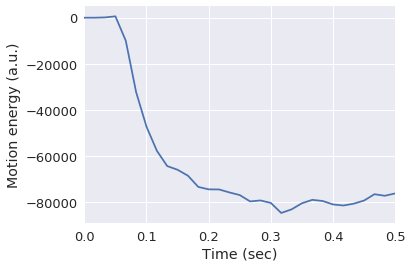

In [17]:
f, ax = plt.subplots()
t = me.filter_grid(numFrames, framerate)
ax.plot(t, dots_energy.sum(axis=(0, 1)))
ax.set(xlim=(0, duration), ylim=(None, None),
       xlabel="Time (sec)",
       ylabel="Motion energy (a.u.)")
f.tight_layout()

We can use a bank of filters with different preferred orientations to model the response of a population of direction-selective cells to a particular stimulus. Alternatively, you can think of this as estimating the tuning curve of the filter system given the set of parameters. Constructing the motion energy profile involves a lot of convolution, so the next cell will take some time to execute.

In [ ]:
%%time
thetas = [-60, -45,  -30, -15, 0, +15, +30, +45, +60]
filter_bank = me.filter_bank(thetas, filter_shape, filter_res)
bank_energy = np.sum(me.apply_motion_energy_filters(dots, filter_bank), axis=(1, 2))

To plot the motion energy profile, we take the mean over time (after cropping to avoid the initial latency period) for each direction.

In [ ]:
t = me.filter_grid(duration / framerate, framerate)
energy_profile = bank_energy[:, t > .2].mean(axis=-1)

In [ ]:
f, ax = plt.subplots()
ax.plot(thetas, energy_profile, "o-")
ax.set(xlabel=r"Motion energy filter orientation ($\theta$)",
       ylabel="Motion energy (a.u.)")
f.tight_layout()